In [1]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
from IPython.display import Image

# PGMPy
from hela.hmm.graphical_models import DynamicBayesianNetwork as dbn
from hela.hmm.graphical_models import structured_inference as dbn_inf

In [2]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2, 2],
                                     n_gaussian_features = 2,
                                     n_categorical_features = 0)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)

In [3]:
fhmm_data = gen.generate_observations(factored_hidden_states)
fhmm_training_spec = gen.generative_model_to_fhmm_training_spec()
# fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
#                                    gen.ns_hidden_states, 
#                                    fhmm_data,
# #                                    categorical_features = list(gen.categorical_values.columns),
#                                    categorical_features = [],
#                                    gaussian_features = list(gen.gaussian_values.columns))

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)

fhmm_model = fhmm_config.to_model()
inf = fhmm_model.load_inference_interface(fhmm_data)

In [4]:
fhmm_data.head()

,gaussian_feature_0,gaussian_feature_1
2020-08-01,-1.034478,-0.191157
2020-08-02,-3.879819,-1.285021
2020-08-03,-3.129034,-2.016322
2020-08-04,-3.042567,-0.829449
2020-08-05,-4.055227,-0.612360


In [5]:
h_t = np.random.rand(len(fhmm_data), 
                        len(fhmm_model.ns_hidden_states), 
                        np.max(fhmm_model.ns_hidden_states))

# Log forward-backward
log_forward = []
log_gamma_h_ts = []
for i in range(5):
    gamma, alpha, beta = inf.log_forward_backward(h_t)
    log_forward.append(alpha)
    h_t = inf.h_t_update(np.exp(gamma), fhmm_data)
    log_gamma_h_ts.append(h_t)
log_path = inf.predict_hidden_states_viterbi(log_gamma_h_ts[-1])

/hela/hela/hmm/factored_models.py:1072: RuntimeWarning: overflow encountered in multiply
  step = h_t[t][m][:, np.newaxis] * model.transition_matrix[m] * viterbi_matrix[t-1][m][:]


In [6]:
h_t = np.random.rand(len(fhmm_data), 
                        len(fhmm_model.ns_hidden_states), 
                        np.max(fhmm_model.ns_hidden_states))

# forward_backward
forward = []
h_ts = []
for i in range(5):
    gamma, alpha, beta = inf.forward_backward(h_t)
    forward.append(alpha)
    h_t = inf.h_t_update(gamma, fhmm_data)
    h_ts.append(h_t)
path = inf.predict_hidden_states_viterbi(h_ts[-1])

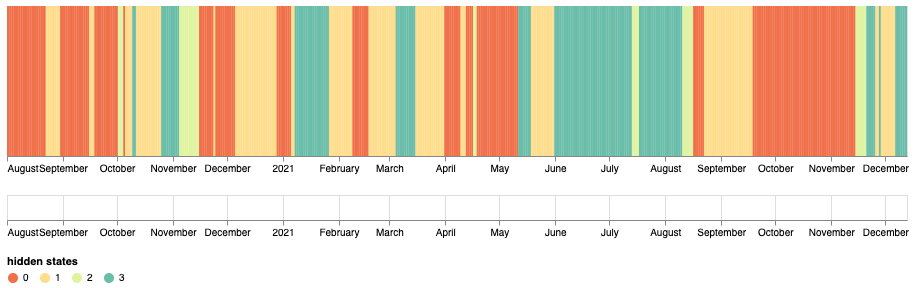

In [7]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

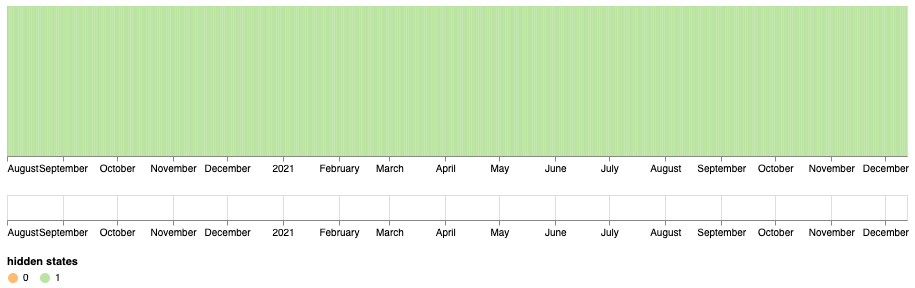

In [8]:
flattened_pred_states = gen.flatten_hidden_state_sequence(path)
hmmplot.draw_states(flattened_pred_states, hide_brush=False)

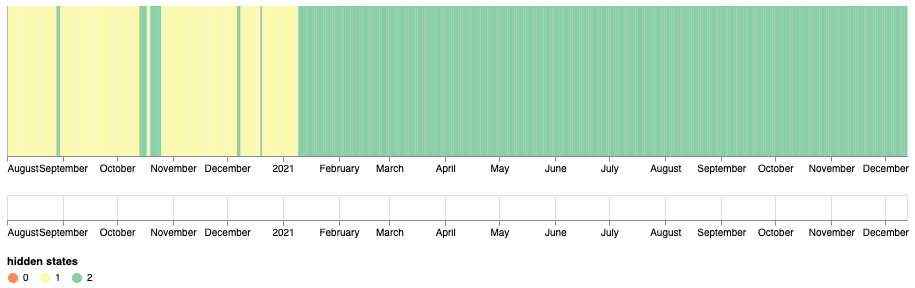

In [9]:
flattened_pred_states = gen.flatten_hidden_state_sequence(log_path)
hmmplot.draw_states(flattened_pred_states, hide_brush=False)

In [10]:
path

,0,1
2020-08-01,1.0,1.0
2020-08-02,0.0,0.0
2020-08-03,0.0,0.0
2020-08-04,0.0,0.0
2020-08-05,0.0,0.0
...,...,...
2021-12-09,0.0,0.0
2021-12-10,0.0,0.0
2021-12-11,0.0,0.0
2021-12-12,0.0,0.0


In [11]:
log_path

,0,1
2020-08-01,1.0,1.0
2020-08-02,0.0,1.0
2020-08-03,0.0,1.0
2020-08-04,0.0,1.0
2020-08-05,0.0,1.0
...,...,...
2021-12-09,0.0,0.0
2021-12-10,0.0,0.0
2021-12-11,0.0,0.0
2021-12-12,0.0,0.0


In [12]:
factored_hidden_states

,0,1
2020-08-01,1,1
2020-08-02,1,1
2020-08-03,1,1
2020-08-04,1,1
2020-08-05,1,1
...,...,...
2021-12-09,0,0
2021-12-10,0,0
2021-12-11,0,0
2021-12-12,0,0
